 ### Importações

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
np.random.seed(241098)
sns.set()
sns.set(rc={'figure.figsize':(10,6)})

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import  RepeatedStratifiedKFold

# Projeto final

### Analíse Exploratoria 

In [4]:

dados = pd.read_excel("https://github.com/alura-cursos/covid-19-clinical/blob/main/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true")
dados.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


Verificando os tipos de dados contidos no dataframe.

In [5]:
dados.dtypes

PATIENT_VISIT_IDENTIFIER        int64
AGE_ABOVE65                     int64
AGE_PERCENTIL                  object
GENDER                          int64
DISEASE GROUPING 1            float64
                               ...   
RESPIRATORY_RATE_DIFF_REL     float64
TEMPERATURE_DIFF_REL          float64
OXYGEN_SATURATION_DIFF_REL    float64
WINDOW                         object
ICU                             int64
Length: 231, dtype: object

Primeiro contato grafico com os dados.

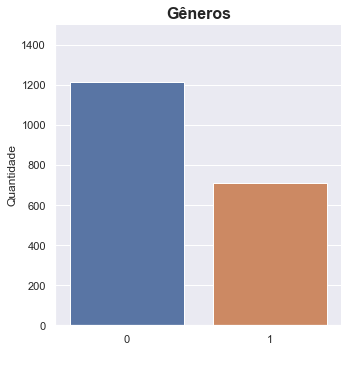

In [6]:
sns.catplot(data=dados, x='GENDER', kind="count")
plt.title('Gêneros',  fontweight="bold", fontsize=16)
plt.ylabel('Quantidade')
plt.ylim(0,1500)
plt.xlabel(' ')
plt.show()

Pórem pode se notar que o fato de haver cinco linhas(fazendo com que 384 pacienntes virem 1924) pra serem contadas no graficos criados, ele se tornam invalidos.
Será preciso deixar cada paciente com uma linha para poder voltar as analises iniciais.
E tambem só será contabilizado nos graficos pacientes que testaram positivos, para isso sera usada a janela 'ABOVE_12' pois contem 1 se o paciente foi em qualquer momento diagnosticado.

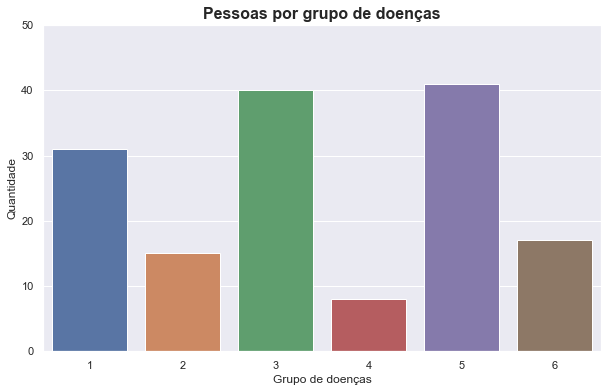

In [7]:
df_janela_unica = dados.loc[(dados['WINDOW'] == 'ABOVE_12') & (dados['ICU'] == 1)]
um = df_janela_unica ['DISEASE GROUPING 1'].sum()
dois =df_janela_unica ['DISEASE GROUPING 2'].sum()
tres =df_janela_unica ['DISEASE GROUPING 3'].sum()
quatro =df_janela_unica ['DISEASE GROUPING 4'].sum()
cinco =df_janela_unica ['DISEASE GROUPING 5'].sum()
seis =df_janela_unica ['DISEASE GROUPING 6'].sum()
lista_grupo = ['1','2','3','4','5','6']
lista_valores = [um, dois, tres, quatro, cinco, seis]

sns.barplot(x=lista_grupo, y=lista_valores)
plt.title('Pessoas por grupo de doenças',  fontweight="bold", fontsize=16)
plt.ylabel('Quantidade')
plt.ylim(0,50)
plt.xlabel('Grupo de doenças')
plt.show()

Das pessoas que testaram positivo, estão mais presentes nos grupos 5 e 3.

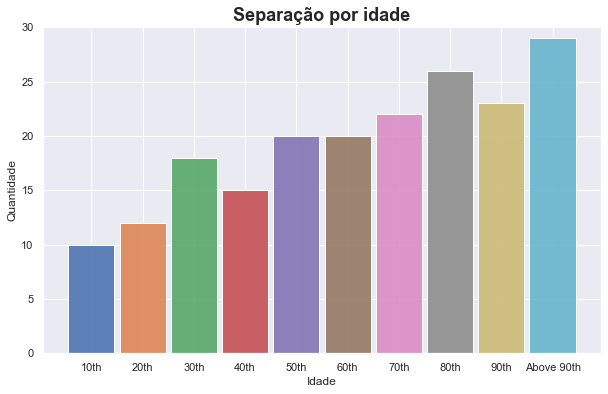

In [8]:
df_janela_unica_hist = df_janela_unica
df_janela_unica_hist['AGE_PERCENTIL'] = pd.Categorical(df_janela_unica_hist['AGE_PERCENTIL'],  ['10th','20th','30th','40th', '50th', '60th', '70th','80th', '90th', 'Above 90th'])

sns.histplot(data=df_janela_unica_hist, x="AGE_PERCENTIL", hue="AGE_PERCENTIL", shrink=.9, alpha=.89,legend=False)

plt.title('Separação por idade',  fontweight="bold", fontsize=18)
plt.ylabel('Quantidade')
plt.ylim(0,30)
plt.xlabel('Idade')
plt.show()

Dá para se observar uma tendencia de crescimento dos internados conforme a idade cresce

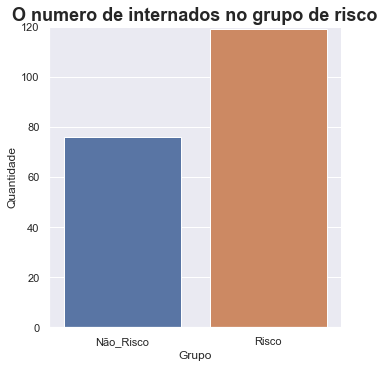

In [9]:
legenda = ['Não_Risco', 'Risco']
pos = np.arange(len(legenda))

sns.catplot(data=df_janela_unica, x='AGE_ABOVE65', kind='count')

plt.title('O numero de internados no grupo de risco',  fontweight="bold", fontsize=18)
plt.ylabel('Quantidade')
plt.ylim(0,120)
plt.xticks(pos, legenda)
plt.xlabel('Grupo')
plt.show()

Como é de se esperar o grupo de risco tem um quantidade bem consideravel a maiis de casos.

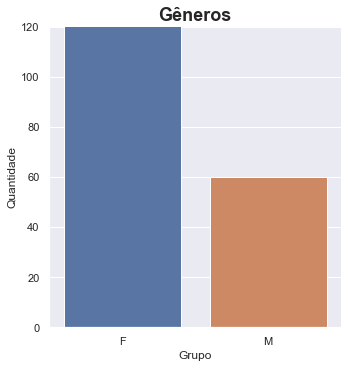

In [10]:
legenda = ['F', 'M']
pos = np.arange(len(legenda))

sns.catplot(data=df_janela_unica, x='GENDER', kind="count")

plt.title('Gêneros',  fontweight="bold", fontsize=18)
plt.ylabel('Quantidade')
plt.ylim(0,120)
plt.xticks(pos, legenda)
plt.xlabel('Grupo')
plt.show()

O sexo feminino parece ser mais sucetivel a internação

In [11]:
# #### preenchendo os valores faltantes
valor_cat = dados.iloc[:, :13]
valor_alvo = dados.iloc[:, -2:]
valor_num_columns = dados.iloc[:,13:-2].columns
valor_num = dados.groupby("PATIENT_VISIT_IDENTIFIER", as_index=False)[list(valor_num_columns)].fillna(method='bfill').fillna(method='ffill')

dados_cheios = pd.concat([valor_cat, valor_num, valor_alvo], ignore_index=True, axis=1)
dados_cheios.columns = dados.columns

In [12]:
# removendo, como no enunciado do problema pede os pacientes que foram internados na janela 0-2
a_remover = dados_cheios.query("WINDOW=='0-2' and ICU==1")['PATIENT_VISIT_IDENTIFIER'].values
dados_cheios_sem_W02_ICU1 = dados_cheios.query("PATIENT_VISIT_IDENTIFIER not in @a_remover")
dados_cheios_sem_W02_ICU1 = dados_cheios_sem_W02_ICU1.dropna()

In [13]:
# removendo as janelas
def prepare_window(rows):
    if(np.any(rows["ICU"])):
        rows.loc[rows["WINDOW"]=="0-2", "ICU"] = 1
    return rows.loc[rows["WINDOW"] == "0-2"]

dados_sem_janelas = dados_cheios_sem_W02_ICU1.groupby("PATIENT_VISIT_IDENTIFIER", as_index=False).apply(prepare_window).reset_index()
dados_sem_janelas = dados_sem_janelas.drop(columns=['level_0', 'level_1', 'WINDOW', 'PATIENT_VISIT_IDENTIFIER'])

ordinal_encoder = OrdinalEncoder()
dados_sem_janelas.AGE_PERCENTIL = ordinal_encoder.fit_transform(dados_sem_janelas[["AGE_PERCENTIL"]])
dados_para_dummy_classifier = dados_sem_janelas

In [14]:
dados_para_dummy_classifier.head()

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
0,1,5.0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
1,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,1
2,0,3.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
3,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.882353,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0
4,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.976190,-0.979798,-0.860870,-0.714460,-0.986481,-1.000000,-0.975891,-0.980129,0


In [15]:
# Aqui fica o pickle para o dummy
with open('data_pick', 'wb') as pickle_file:
    pickle.dump(dados_para_dummy_classifier, pickle_file)